# Tensorflow.keras implementation of full precision CNN for CIFAR 10 
##  https://arxiv.org/abs/1802.08530
## M. D. McDonnell, 
## Training wide residual networks for deployment using a single bit for each weight
## ICLR, 2018

In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import tensorflow
print('Tensorflow version = ',tensorflow.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, History

#from tensorflow.keras import backend as K

from ResNetModel import resnet
from Utils import cutout,LR_WarmRestart,GetDataGen,plot_history

Tensorflow version =  1.13.1


In [2]:
#params
WhichDataSet = 'CIFAR10'
#WhichDataSet = 'CIFAR100'
init_lr = 0.1
epochs = 254
batch_size = 125
My_wd=5e-4/2
resnet_width = 10
resnet_depth = 20
UseBinary=False
UseCutout=True
Loss = 'categorical_crossentropy'
Optimizer = SGD(lr=init_lr,decay=0.0, momentum=0.9, nesterov=False)
Metrics = ['accuracy']
ModelsPath = 'TrainedModels/Tensorflow.keras/'

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#load and prepare data
if WhichDataSet == 'CIFAR10':
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()
num_classes = np.unique(y_train).shape[0]
K_train = x_train.shape[0]
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


In [4]:
#fdefine a datagen or generating training samples with flip and pad/crop augmentation, and if set to True, with cutout augmentation
dataGenerator = GetDataGen(UseCutout)

#define and compile the model
model = resnet(UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,wd=My_wd,width=resnet_width)
model.compile(loss=Loss ,optimizer = Optimizer, metrics = Metrics)

#print  the model
model.summary()

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [1.0,3.0, 7.0, 15.0, 31.0, 63.0,127.0,255.0]) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 160)  4320        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 32, 32, 160)  320         conv2d[0][0]                     
__________________________________________________________________________________________________
activation

In [5]:
history = model.fit_generator(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =steps_per_epoch)

Instructions for updating:
Use tf.cast instead.

 Start of Epoch Learning Rate = 0.100000
Epoch 1/254
10000/10000 [==============================] - 7s 694us/sample - loss: 3.8586 - acc: 0.5636

 End of Epoch Learning Rate = 0.050005
400/400 [==============================] - 120s 300ms/step - loss: 4.4693 - acc: 0.4782 - val_loss: 3.8586 - val_acc: 0.5636

 Start of Epoch Learning Rate = 0.050005
Epoch 2/254
10000/10000 [==============================] - 7s 653us/sample - loss: 3.2914 - acc: 0.7279

 End of Epoch Learning Rate = 0.000010
400/400 [==============================] - 116s 290ms/step - loss: 3.5252 - acc: 0.6636 - val_loss: 3.2914 - val_acc: 0.7279

 Start of Epoch Learning Rate = 0.100000
Epoch 3/254
10000/10000 [==============================] - 6s 648us/sample - loss: 2.8187 - acc: 0.6622

 End of Epoch Learning Rate = 0.085357
400/400 [==============================] - 118s 294ms/step - loss: 3.1646 - acc: 0.6464 - val_loss: 2.8187 - val_acc: 0.6622

 Start of Epoch Le

10000/10000 [==============================] - 7s 654us/sample - loss: 0.7295 - acc: 0.8966

 End of Epoch Learning Rate = 0.014653
400/400 [==============================] - 116s 291ms/step - loss: 0.7369 - acc: 0.9101 - val_loss: 0.7295 - val_acc: 0.8966

 Start of Epoch Learning Rate = 0.014653
Epoch 27/254
10000/10000 [==============================] - 6s 647us/sample - loss: 0.6511 - acc: 0.9253

 End of Epoch Learning Rate = 0.008436
400/400 [==============================] - 116s 290ms/step - loss: 0.6941 - acc: 0.9252 - val_loss: 0.6511 - val_acc: 0.9253

 Start of Epoch Learning Rate = 0.008436
Epoch 28/254
10000/10000 [==============================] - 7s 664us/sample - loss: 0.6158 - acc: 0.9393

 End of Epoch Learning Rate = 0.003816
400/400 [==============================] - 116s 291ms/step - loss: 0.6639 - acc: 0.9362 - val_loss: 0.6158 - val_acc: 0.9393

 Start of Epoch Learning Rate = 0.003816
Epoch 29/254
10000/10000 [==============================] - 6s 644us/sample -

10000/10000 [==============================] - 7s 660us/sample - loss: 0.7779 - acc: 0.8755

 End of Epoch Learning Rate = 0.022229
400/400 [==============================] - 116s 290ms/step - loss: 0.7074 - acc: 0.9189 - val_loss: 0.7779 - val_acc: 0.8755

 Start of Epoch Learning Rate = 0.022229
Epoch 53/254
10000/10000 [==============================] - 7s 665us/sample - loss: 0.7277 - acc: 0.8958

 End of Epoch Learning Rate = 0.018289
400/400 [==============================] - 117s 293ms/step - loss: 0.6844 - acc: 0.9280 - val_loss: 0.7277 - val_acc: 0.8958

 Start of Epoch Learning Rate = 0.018289
Epoch 54/254
10000/10000 [==============================] - 7s 658us/sample - loss: 0.6933 - acc: 0.9058

 End of Epoch Learning Rate = 0.014653
400/400 [==============================] - 116s 291ms/step - loss: 0.6586 - acc: 0.9369 - val_loss: 0.6933 - val_acc: 0.9058

 Start of Epoch Learning Rate = 0.014653
Epoch 55/254
10000/10000 [==============================] - 6s 649us/sample -

10000/10000 [==============================] - 7s 652us/sample - loss: 1.1524 - acc: 0.7612

 End of Epoch Learning Rate = 0.085357
400/400 [==============================] - 116s 290ms/step - loss: 0.9388 - acc: 0.8617 - val_loss: 1.1524 - val_acc: 0.7612

 Start of Epoch Learning Rate = 0.085357
Epoch 79/254
10000/10000 [==============================] - 7s 654us/sample - loss: 1.1148 - acc: 0.7879

 End of Epoch Learning Rate = 0.083580
400/400 [==============================] - 116s 290ms/step - loss: 0.9350 - acc: 0.8607 - val_loss: 1.1148 - val_acc: 0.7879

 Start of Epoch Learning Rate = 0.083580
Epoch 80/254
10000/10000 [==============================] - 6s 641us/sample - loss: 1.0385 - acc: 0.8065

 End of Epoch Learning Rate = 0.081721
400/400 [==============================] - 116s 291ms/step - loss: 0.9330 - acc: 0.8626 - val_loss: 1.0385 - val_acc: 0.8065

 Start of Epoch Learning Rate = 0.081721
Epoch 81/254
10000/10000 [==============================] - 6s 643us/sample -

10000/10000 [==============================] - 6s 649us/sample - loss: 0.7296 - acc: 0.8978

 End of Epoch Learning Rate = 0.026438
400/400 [==============================] - 116s 290ms/step - loss: 0.6963 - acc: 0.9251 - val_loss: 0.7296 - val_acc: 0.8978

 Start of Epoch Learning Rate = 0.026438
Epoch 105/254
10000/10000 [==============================] - 6s 650us/sample - loss: 0.7156 - acc: 0.8975

 End of Epoch Learning Rate = 0.024302
400/400 [==============================] - 117s 291ms/step - loss: 0.6891 - acc: 0.9263 - val_loss: 0.7156 - val_acc: 0.8975

 Start of Epoch Learning Rate = 0.024302
Epoch 106/254
10000/10000 [==============================] - 7s 651us/sample - loss: 0.6998 - acc: 0.9059

 End of Epoch Learning Rate = 0.022229
400/400 [==============================] - 116s 291ms/step - loss: 0.6719 - acc: 0.9319 - val_loss: 0.6998 - val_acc: 0.9059

 Start of Epoch Learning Rate = 0.022229
Epoch 107/254
10000/10000 [==============================] - 6s 640us/sampl

10000/10000 [==============================] - 6s 645us/sample - loss: 1.3021 - acc: 0.7235

 End of Epoch Learning Rate = 0.099759
400/400 [==============================] - 116s 290ms/step - loss: 0.9775 - acc: 0.8532 - val_loss: 1.3021 - val_acc: 0.7235

 Start of Epoch Learning Rate = 0.099759
Epoch 131/254
10000/10000 [==============================] - 6s 649us/sample - loss: 1.1829 - acc: 0.7628

 End of Epoch Learning Rate = 0.099624
400/400 [==============================] - 117s 292ms/step - loss: 0.9761 - acc: 0.8542 - val_loss: 1.1829 - val_acc: 0.7628

 Start of Epoch Learning Rate = 0.099624
Epoch 132/254
10000/10000 [==============================] - 6s 649us/sample - loss: 1.1420 - acc: 0.7863

 End of Epoch Learning Rate = 0.099459
400/400 [==============================] - 117s 291ms/step - loss: 0.9807 - acc: 0.8550 - val_loss: 1.1420 - val_acc: 0.7863

 Start of Epoch Learning Rate = 0.099459
Epoch 133/254
10000/10000 [==============================] - 6s 645us/sampl

10000/10000 [==============================] - 6s 640us/sample - loss: 1.1086 - acc: 0.7923

 End of Epoch Learning Rate = 0.087049
400/400 [==============================] - 116s 291ms/step - loss: 0.9358 - acc: 0.8678 - val_loss: 1.1086 - val_acc: 0.7923

 Start of Epoch Learning Rate = 0.087049
Epoch 157/254
10000/10000 [==============================] - 6s 641us/sample - loss: 1.0846 - acc: 0.8093

 End of Epoch Learning Rate = 0.086214
400/400 [==============================] - 116s 290ms/step - loss: 0.9359 - acc: 0.8667 - val_loss: 1.0846 - val_acc: 0.8093

 Start of Epoch Learning Rate = 0.086214
Epoch 158/254
10000/10000 [==============================] - 6s 647us/sample - loss: 1.3014 - acc: 0.7147

 End of Epoch Learning Rate = 0.085357
400/400 [==============================] - 116s 291ms/step - loss: 0.9310 - acc: 0.8680 - val_loss: 1.3014 - val_acc: 0.7147

 Start of Epoch Learning Rate = 0.085357
Epoch 159/254
10000/10000 [==============================] - 6s 644us/sampl

10000/10000 [==============================] - 7s 653us/sample - loss: 0.9580 - acc: 0.8434

 End of Epoch Learning Rate = 0.059759
400/400 [==============================] - 117s 292ms/step - loss: 0.8476 - acc: 0.8870 - val_loss: 0.9580 - val_acc: 0.8434

 Start of Epoch Learning Rate = 0.059759
Epoch 183/254
10000/10000 [==============================] - 7s 680us/sample - loss: 0.8372 - acc: 0.8887

 End of Epoch Learning Rate = 0.058552
400/400 [==============================] - 116s 291ms/step - loss: 0.8336 - acc: 0.8925 - val_loss: 0.8372 - val_acc: 0.8887

 Start of Epoch Learning Rate = 0.058552
Epoch 184/254
10000/10000 [==============================] - 6s 649us/sample - loss: 0.9147 - acc: 0.8511

 End of Epoch Learning Rate = 0.057341
400/400 [==============================] - 116s 291ms/step - loss: 0.8329 - acc: 0.8920 - val_loss: 0.9147 - val_acc: 0.8511

 Start of Epoch Learning Rate = 0.057341
Epoch 185/254
10000/10000 [==============================] - 7s 652us/sampl

10000/10000 [==============================] - 7s 661us/sample - loss: 0.8096 - acc: 0.8744

 End of Epoch Learning Rate = 0.028629
400/400 [==============================] - 116s 290ms/step - loss: 0.6954 - acc: 0.9267 - val_loss: 0.8096 - val_acc: 0.8744

 Start of Epoch Learning Rate = 0.028629
Epoch 209/254
10000/10000 [==============================] - 7s 659us/sample - loss: 0.7032 - acc: 0.9140

 End of Epoch Learning Rate = 0.027527
400/400 [==============================] - 116s 291ms/step - loss: 0.6905 - acc: 0.9280 - val_loss: 0.7032 - val_acc: 0.9140

 Start of Epoch Learning Rate = 0.027527
Epoch 210/254
10000/10000 [==============================] - 6s 648us/sample - loss: 0.7942 - acc: 0.8822

 End of Epoch Learning Rate = 0.026438
400/400 [==============================] - 116s 290ms/step - loss: 0.6755 - acc: 0.9334 - val_loss: 0.7942 - val_acc: 0.8822

 Start of Epoch Learning Rate = 0.026438
Epoch 211/254
10000/10000 [==============================] - 6s 649us/sampl

10000/10000 [==============================] - 7s 657us/sample - loss: 0.5476 - acc: 0.9476

 End of Epoch Learning Rate = 0.005913
400/400 [==============================] - 117s 291ms/step - loss: 0.5094 - acc: 0.9745 - val_loss: 0.5476 - val_acc: 0.9476

 Start of Epoch Learning Rate = 0.005913
Epoch 235/254
10000/10000 [==============================] - 7s 657us/sample - loss: 0.5541 - acc: 0.9482

 End of Epoch Learning Rate = 0.005348
400/400 [==============================] - 116s 291ms/step - loss: 0.5034 - acc: 0.9768 - val_loss: 0.5541 - val_acc: 0.9482

 Start of Epoch Learning Rate = 0.005348
Epoch 236/254
10000/10000 [==============================] - 7s 659us/sample - loss: 0.5359 - acc: 0.9537

 End of Epoch Learning Rate = 0.004810
400/400 [==============================] - 116s 291ms/step - loss: 0.4977 - acc: 0.9782 - val_loss: 0.5359 - val_acc: 0.9537

 Start of Epoch Learning Rate = 0.004810
Epoch 237/254
10000/10000 [==============================] - 6s 647us/sampl

In [6]:
#get final performance
y_pred = model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Test accuracy (%): 96.49


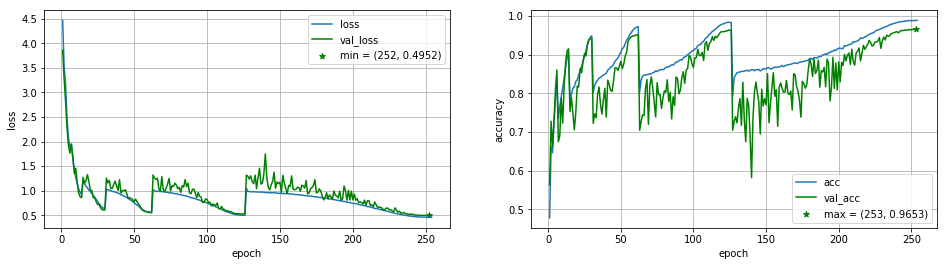

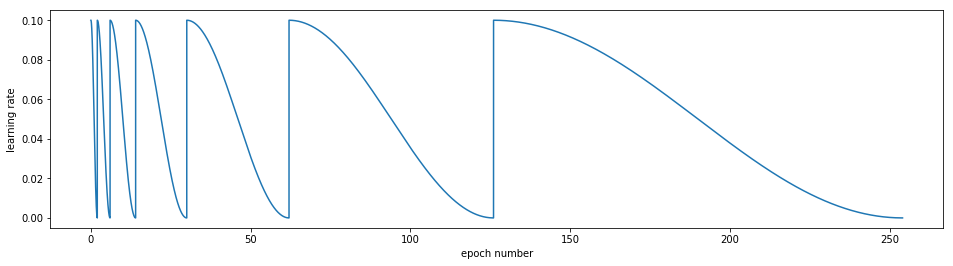

In [7]:
#plot loss and accuracy
plot_history(model.history.history)

#plot learning rate schedule
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,len(lr_scheduler.lr_used))/steps_per_epoch,lr_scheduler.lr_used)
plt.xlabel('epoch number')
plt.ylabel('learning rate')
plt.show()

In [8]:
#save the weigts used for updating
model.save_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_32bit_model.h5')